# Gravity Model

## Der Datensatz muss "optim_trip_summary.csv" heißen

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# CSV laden
df = pd.read_csv("optim_trip_summary.csv")

# Alle einzigartigen Städte finden
all_cities = sorted(set(df['start_name']).union(set(df['end_name'])))
city_to_idx = {city: i for i, city in enumerate(all_cities)}
n = len(all_cities)

# OD-Matrix initialisieren
observed_flows = np.zeros((n, n))
distance_matrix = np.full((n, n), np.nan)  # NaN zum Test auf fehlende Werte

# Population (angenommen du hast 'start_population' und 'end_population')
# => Mittelwert pro Stadt nehmen (falls Stadt mehrfach als Start/Ziel vorkommt)
pop_start = df.groupby('start_name')['start_population'].mean()
pop_end = df.groupby('end_name')['end_population'].mean()

# Kombinieren beider Quellen
all_pops = pd.concat([pop_start, pop_end], axis=1).mean(axis=1).to_dict()

# Reihenfolge-synchronisiertes Bevölkerungsarray
population_array = np.array([all_pops[city] for city in all_cities])

# Matrix füllen
for _, row in df.iterrows():
    i = city_to_idx[row['start_name']]
    j = city_to_idx[row['end_name']]
    observed_flows[i, j] = row['trips']
    distance_matrix[i, j] = row['distance']

# Fehlende Distanzen durch sehr große Werte ersetzen (z. B. 1000 km)
distance_matrix[np.isnan(distance_matrix)] = 1e6

print("OD-Matrix, Distanzmatrix und Bevölkerungsarray erfolgreich erstellt.")
print(f"OD-Matrix-Größe: {observed_flows.shape}")


# === 2. Gravity-Modell Funktion ===
def compute_gravity_flows(distance_matrix, population_array, beta=2.0):
    n = len(population_array)
    flow_matrix = np.zeros((n, n))
    
    for i in tqdm(range(n), desc="Computing flows"):
        for j in range(n):
            if i != j and distance_matrix[i, j] > 0:
                flow = (population_array[i] * population_array[j]) / (distance_matrix[i, j] ** beta)
                flow_matrix[i, j] = max(flow, 1e-10)  # Mindestfluss
                
    return flow_matrix

# === 3. Flüsse skalieren auf reale Gesamtzahl ===
def normalize_flows(flow_matrix, total_trips=None):
    flow_matrix[~np.isfinite(flow_matrix)] = 0
    total_flow = np.sum(flow_matrix)
    
    if total_flow == 0:
        print("Warnung: Gesamtfluss ist 0.")
        return flow_matrix
    
    if total_trips is None:
        return flow_matrix / total_flow  # Wahrscheinlichkeiten
    else:
        return flow_matrix * (total_trips / total_flow)  # Skalierte Flüsse

# === 4. Parameter einstellen und berechnen ===
beta = 1.4  # Distanz-Abklingparameter, anpassen oder optimieren
print(f"Verwende beta = {beta}")

# Gravity Modell Flüsse berechnen
predicted_flows = compute_gravity_flows(distance_matrix, population_array, beta=beta)

# Auf reale Trips skalieren
predicted_flows_scaled = normalize_flows(predicted_flows, total_trips=observed_flows.sum())

# === 5. Ergebnis evaluieren ===
from sklearn.metrics import mean_squared_error

# RMSE zwischen beobachteten und vorhergesagten Trips (flattened arrays)
rmse = np.sqrt(mean_squared_error(observed_flows.flatten(), predicted_flows_scaled.flatten()))
print(f"RMSE zwischen beobachteten und vorhergesagten Flüssen: {rmse:.4f}")

# === 6. Optional: Ergebnisse in DataFrame und speichern ===
results = []
for i in range(n):
    for j in range(n):
        if i != j:
            results.append({
                'start_name': all_cities[i],
                'end_name': all_cities[j],
                'observed_trips': observed_flows[i, j],
                'predicted_trips': predicted_flows_scaled[i, j],
                'distance': distance_matrix[i, j],
                'pop_start': population_array[i],
                'pop_end': population_array[j]
            })

df_results = pd.DataFrame(results)
df_results.to_csv("gravity_model_predictions.csv", index=False)
print("Ergebnisse in 'gravity_model_predictions.csv' gespeichert.")

OD-Matrix, Distanzmatrix und Bevölkerungsarray erfolgreich erstellt.
OD-Matrix-Größe: (361, 361)
Verwende beta = 1.4


Computing flows: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 361/361 [00:00<00:00, 2633.75it/s]


RMSE zwischen beobachteten und vorhergesagten Flüssen: 158.5635
Ergebnisse in 'gravity_model_predictions.csv' gespeichert.


📊 Verwendete Distanzklassen: [(0, 1), (1, 2), (2, 10)]
✅ 10796 Trips in Range 0-1 km gesamplet
✅ 33622 Trips in Range 1-2 km gesamplet
✅ 55553 Trips in Range 2-10 km gesamplet

📦 Insgesamt gesamplete Trips: 99971

📈 Statistische Kennzahlen der gesampleten Distanzen:
count    99971.000000
mean         2.193773
std          1.114611
min          0.159744
25%          1.321792
50%          2.123141
75%          2.757606
max          9.218528
dtype: float64


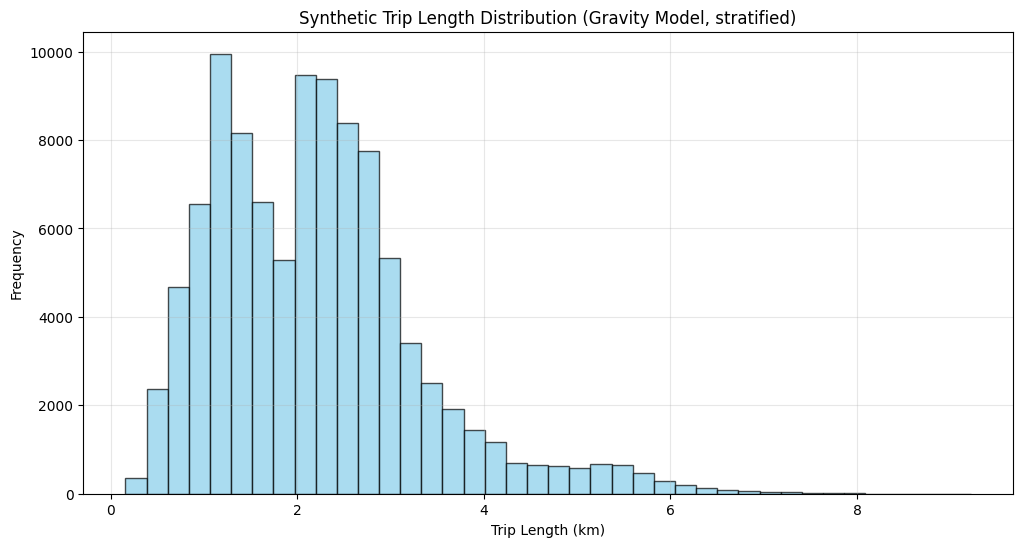

In [2]:
import matplotlib.pyplot as plt

def sample_od_pairs_stratified_auto(flow_probs, distance_matrix, observed_distances, num_samples=100000, num_bins=3):
    """
    Stratified sampling von OD-Paaren mit automatischer Distanzklasseneinteilung basierend auf den beobachteten Daten.
    
    Args:
        flow_probs: Matrix mit Flusswahrscheinlichkeiten
        distance_matrix: Matrix mit Entfernungen
        observed_distances: Serie der beobachteten Distanzen
        num_samples: Anzahl der zu samplenden Trips
        num_bins: Anzahl der Distanzklassen
        
    Returns:
        Liste der gesampleten Distanzen und OD-Paare
    """
    
    # Distanzklassen automatisch aus realen Daten bestimmen
    distance_bins = pd.qcut(observed_distances, q=num_bins, duplicates='drop')
    bin_edges = distance_bins.unique().categories
    distance_ranges = [(int(c.left), int(c.right)) for c in bin_edges]
    print(f"📊 Verwendete Distanzklassen: {distance_ranges}")
    
    n = flow_probs.shape[0]
    flat_probs = flow_probs.flatten()
    flat_distances = distance_matrix.flatten()
    flat_indices = np.arange(n * n)
    
    valid_mask = (flat_probs > 0) & (flat_distances > 0)
    valid_indices = flat_indices[valid_mask]

    # Umwandeln in (i,j)-Paare
    valid_pairs = [np.unravel_index(idx, (n, n)) for idx in valid_indices]
    valid_probs = flat_probs[valid_mask]
    valid_distances = flat_distances[valid_mask]


    # Gruppiere nach Distanzklassen
    range_indices = {}
    for min_dist, max_dist in distance_ranges:
        range_mask = (valid_distances >= min_dist) & (valid_distances <= max_dist)
        range_indices[(min_dist, max_dist)] = np.where(range_mask)[0]

    # Anzahl beobachteter Trips pro Range
    observed_counts = {}
    total_observed = len(observed_distances)
    for min_dist, max_dist in distance_ranges:
        observed_counts[(min_dist, max_dist)] = len(observed_distances[(observed_distances >= min_dist) & (observed_distances <= max_dist)])

    # Sample-Anzahl je Range proportional zur Realität
    samples_per_range = {
        r: max(100, int(num_samples * observed_counts[r] / total_observed))
        for r in range_indices.keys()
    }

    sampled_distances = []
    sampled_pairs = []

    for (min_dist, max_dist), indices in range_indices.items():
        if len(indices) == 0:
            print(f"⚠️ Keine gültigen OD-Paare in Range {min_dist}-{max_dist} km")
            continue

        range_probs = valid_probs[indices]
        range_probs = range_probs / range_probs.sum() if range_probs.sum() > 0 else np.ones(len(indices)) / len(indices)
        range_samples = samples_per_range[(min_dist, max_dist)]
        sampled_idx = np.random.choice(indices, size=range_samples, p=range_probs, replace=True)

        sampled_distances.extend(valid_distances[i] for i in sampled_idx)
        sampled_pairs.extend(valid_pairs[i] for i in sampled_idx)
        print(f"✅ {len(sampled_idx)} Trips in Range {min_dist}-{max_dist} km gesamplet")

    print(f"\n📦 Insgesamt gesamplete Trips: {len(sampled_distances)}")
    return pd.Series(sampled_distances), sampled_pairs

# Verwende die beobachteten Distanzen aus deinem Original-DataFrame
observed_distances = df['distance']

# Stratified Sampling von 100.000 synthetischen Trips
synthetic_tld, sampled_pairs = sample_od_pairs_stratified_auto(
    flow_probs=predicted_flows_scaled,
    distance_matrix=distance_matrix,
    observed_distances=observed_distances,
    num_samples=100000,
    num_bins=3  # oder 4/5 für feinere Auflösung
)

# Optional: Filter extrem kurzer/langer Trips (z. B. unter 50 oder über 900 km)
synthetic_tld = synthetic_tld[(synthetic_tld >= 0) & (synthetic_tld <= 90)]

# Statistiken
print("\n📈 Statistische Kennzahlen der gesampleten Distanzen:")
print(synthetic_tld.describe())

# Plot
plt.figure(figsize=(12, 6))
plt.hist(synthetic_tld, bins=40, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Synthetic Trip Length Distribution (Gravity Model, stratified)')
plt.xlabel('Trip Length (km)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()



[INFO] Section 4: Vergleich der synthetischen und beobachteten TLD
[STATS] Kolmogorov-Smirnov: 0.1003, p = 0.0000
[STATS] Earth Mover’s Distance: 0.3054
[STATS] Chi²-Distanz: 37554.2962


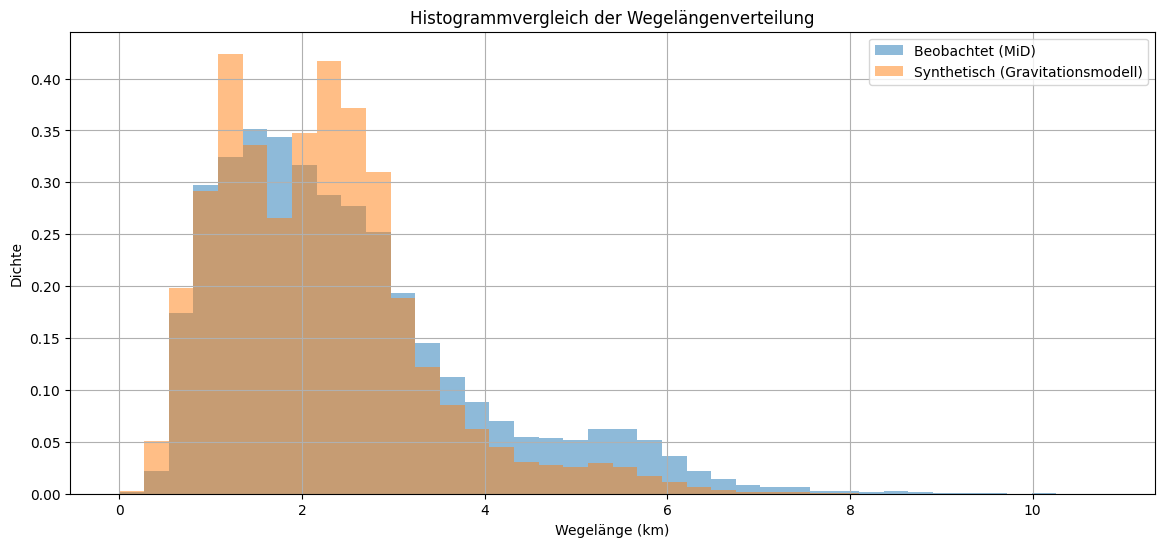

In [6]:
# -----------------------------------------------------------
# Section 4: Compare Predicted TLD to Observed TLD
# -----------------------------------------------------------

from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance
import seaborn as sns

%matplotlib inline

print("\n[INFO] Section 4: Vergleich der synthetischen und beobachteten TLD")

# Beobachtete Wegelängen extrahieren
observed_tld = df['distance']

# Sicherstellen, dass wir sinnvolle Grenzen definieren
MIN_TRIP_LENGTH = min(observed_tld.min(), synthetic_tld.min())
MAX_TRIP_LENGTH = max(observed_tld.max(), synthetic_tld.max())

# Binning für Histogrammvergleich
bins = np.linspace(MIN_TRIP_LENGTH, MAX_TRIP_LENGTH, 41)  # 40 gleich breite Bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Histogramme berechnen
hist_observed, _ = np.histogram(observed_tld, bins=bins, density=True)
hist_synthetic, _ = np.histogram(synthetic_tld, bins=bins, density=True)

# ECDF-Funktion
def ecdf(x):
    x_sorted = np.sort(x)
    y = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
    return x_sorted, y

# ECDFs berechnen
x_obs, cdf_obs = ecdf(observed_tld)
x_syn, cdf_syn = ecdf(synthetic_tld)

# Statistische Tests
ks_stat, ks_pval = ks_2samp(observed_tld, synthetic_tld)
emd = wasserstein_distance(observed_tld, synthetic_tld)
chi2_stat = np.sum((hist_observed - hist_synthetic)**2 / (hist_synthetic + 1e-10))

print(f"[STATS] Kolmogorov-Smirnov: {ks_stat:.4f}, p = {ks_pval:.4f}")
print(f"[STATS] Earth Mover’s Distance: {emd:.4f}")
print(f"[STATS] Chi²-Distanz: {chi2_stat:.4f}")

# Visualisierungen

# 1. Histogrammvergleich
plt.figure(figsize=(14, 6))
plt.hist(observed_tld, bins=bins, alpha=0.5, density=True, label='Beobachtet (MiD)')
plt.hist(synthetic_tld, bins=bins, alpha=0.5, density=True, label='Synthetisch (Gravitationsmodell)')
plt.title('Histogrammvergleich der Wegelängenverteilung')
plt.xlabel('Wegelänge (km)')
plt.ylabel('Dichte')
plt.legend()
#plt.grid(alpha=0.3)
plt.grid(True)
plt.show()

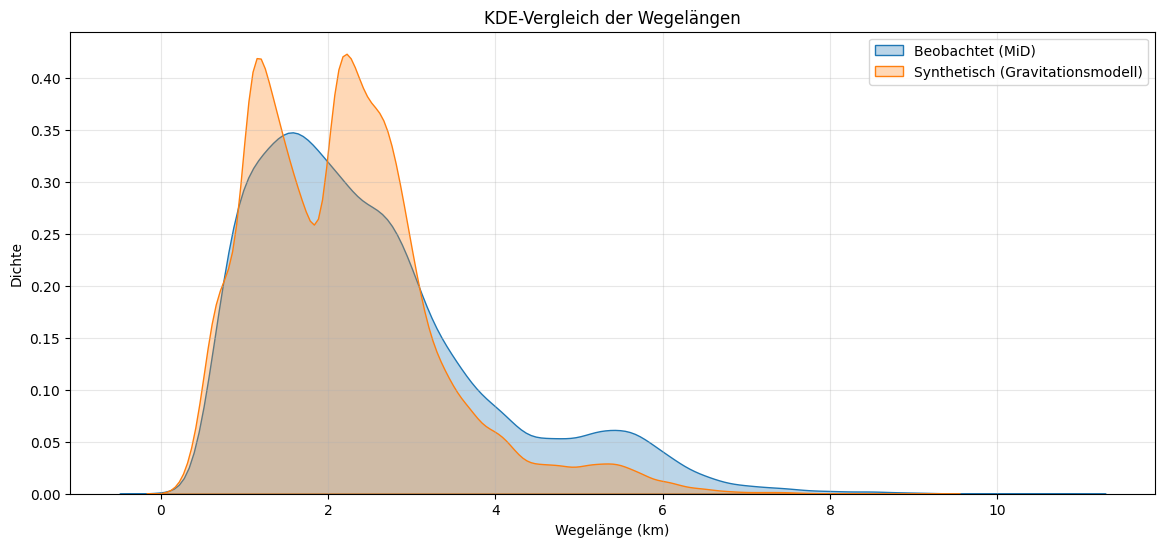

In [7]:
# 2. KDE-Vergleich
plt.figure(figsize=(14, 6))
sns.kdeplot(observed_tld, label='Beobachtet (MiD)', fill=True, alpha=0.3)
sns.kdeplot(synthetic_tld, label='Synthetisch (Gravitationsmodell)', fill=True, alpha=0.3)
plt.title('KDE-Vergleich der Wegelängen')
plt.xlabel('Wegelänge (km)')
plt.ylabel('Dichte')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

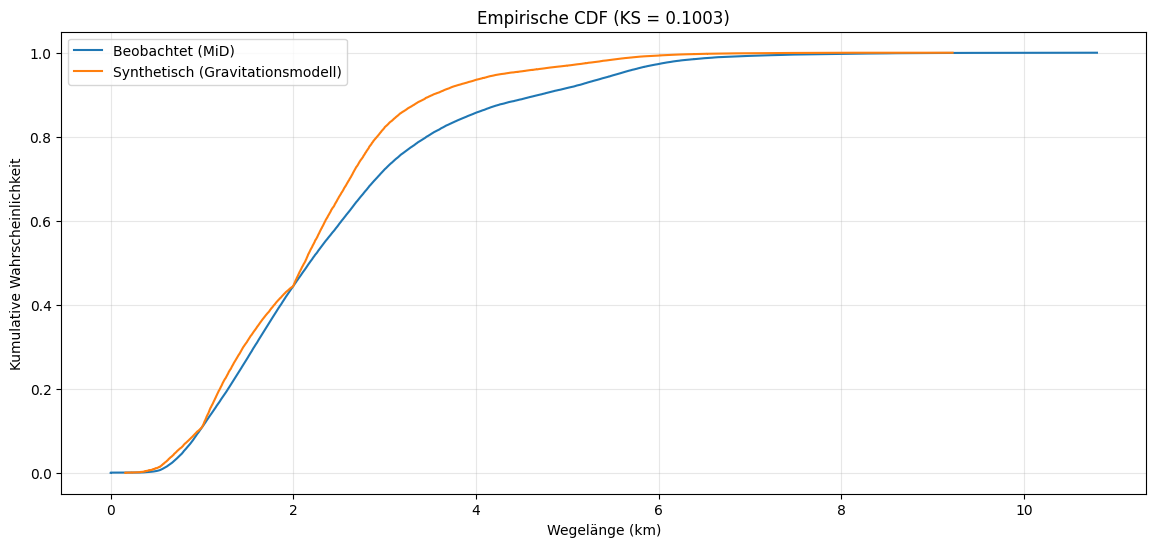

In [8]:
# 3. ECDF-Vergleich
plt.figure(figsize=(14, 6))
plt.plot(x_obs, cdf_obs, label='Beobachtet (MiD)')
plt.plot(x_syn, cdf_syn, label='Synthetisch (Gravitationsmodell)')
plt.title(f'Empirische CDF (KS = {ks_stat:.4f})')
plt.xlabel('Wegelänge (km)')
plt.ylabel('Kumulative Wahrscheinlichkeit')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

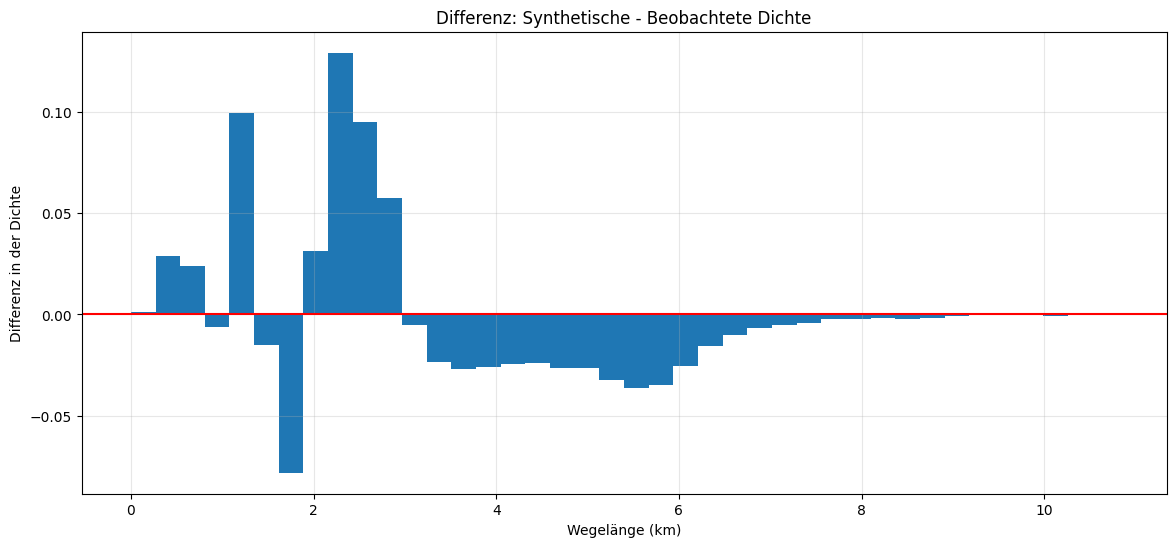

In [9]:
# 4. Histogrammunterschied
plt.figure(figsize=(14, 6))
plt.bar(bin_centers, hist_synthetic - hist_observed, width=bins[1] - bins[0])
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Differenz: Synthetische - Beobachtete Dichte')
plt.xlabel('Wegelänge (km)')
plt.ylabel('Differenz in der Dichte')
plt.grid(alpha=0.3)
plt.show()

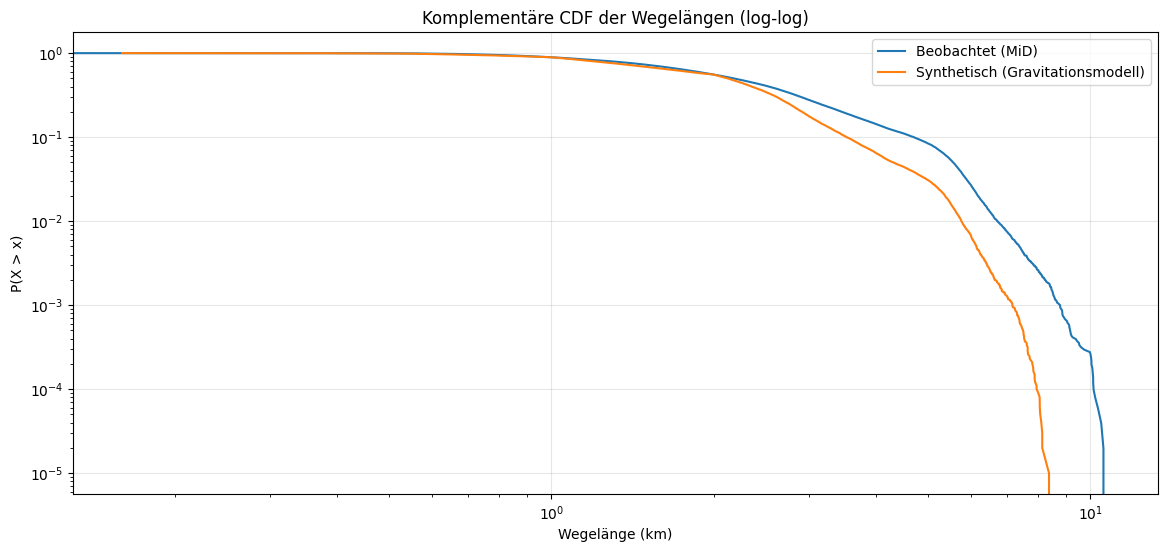

In [10]:
# 5. CCDF-Vergleich
def ccdf(x):
    x_sorted = np.sort(x)
    return x_sorted, 1 - np.arange(1, len(x_sorted) + 1) / len(x_sorted)

x_obs_ccdf, ccdf_obs = ccdf(observed_tld)
x_syn_ccdf, ccdf_syn = ccdf(synthetic_tld)

plt.figure(figsize=(14, 6))
plt.loglog(x_obs_ccdf, ccdf_obs, label='Beobachtet (MiD)')
plt.loglog(x_syn_ccdf, ccdf_syn, label='Synthetisch (Gravitationsmodell)')
plt.title('Komplementäre CDF der Wegelängen (log-log)')
plt.xlabel('Wegelänge (km)')
plt.ylabel('P(X > x)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()